<a href="https://colab.research.google.com/github/vivekbiju/XAI/blob/main/CustomCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow
!pip install seaborn
!pip install matplotlib
!pip install kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.4 MB/s eta 0:00:00


In [3]:
#Importing libraries
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [4]:
path = kagglehub.dataset_download("bhaveshmittal/melanoma-cancer-dataset")
print("Path to dataset files:", path)

# Defining train_path and test_path
train_path = os.path.join(path, "train")
test_path = os.path.join(path, "test")

100%|██████████| 79.4M/79.4M [00:00<00:00, 180MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bhaveshmittal/melanoma-cancer-dataset/versions/1


In [5]:
# Image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescaling only for Testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Training Data
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Load Testing Data
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Print class labels
print("Class Mapping:", train_generator.class_indices)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Class Mapping: {'Benign': 0, 'Malignant': 1}


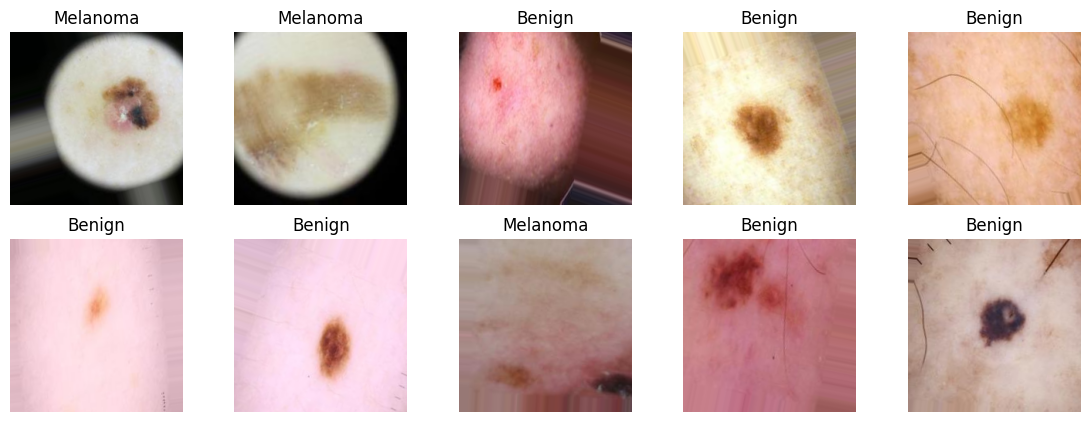

In [18]:
# Display some sample images from dataset
def plot_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(14, 13))
    for i in range(10):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        plt.title("Melanoma" if labels[i] == 1 else "Benign")
        plt.axis("off")
    plt.show()

# Plot Training Images
plot_images(train_generator)

In [19]:
# Building the CNN model
model = models.Sequential([
    # 1st Convolution Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    # 2nd Convolution Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # 3rd Convolution Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flattening Layer
    layers.Flatten(),

    # Fully Connected Layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout to reduce overfitting
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam',  # Optimizer for faster convergence
              loss='binary_crossentropy',  # Binary classification loss
              metrics=['accuracy'])  # Accuracy metric

# Model Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# EarlyStopping to stop training when the model stops improving
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau to reduce the learning rate if the model stops improving
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

start_time = time.time()
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=15,  # Set number of epochs to train the model
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler]
)
end_time = time.time()
total_time = end_time - start_time
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"\nTotal training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")


Epoch 1/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 93s 249ms/step - accuracy: 0.7309 - loss: 0.6466 - val_accuracy: 0.8367 - val_loss: 0.3578 - learning_rate: 0.0010
Epoch 2/15
  1/371 ━━━━━━━━━━━━━━━━━━━━ 37s 103ms/step - accuracy: 0.9062 - loss: 0.2275

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9062 - loss: 0.2275 - val_accuracy: 0.8367 - val_loss: 0.3541 - learning_rate: 0.0010
Epoch 3/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 94s 252ms/step - accuracy: 0.8171 - loss: 0.3972 - val_accuracy: 0.8090 - val_loss: 0.4226 - learning_rate: 0.0010
Epoch 4/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7188 - loss: 0.7342 - val_accuracy: 0.8150 - val_loss: 0.4068 - learning_rate: 0.0010
Epoch 5/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 92s 248ms/step - accuracy: 0.8401 - loss: 0.3670 - val_accuracy: 0.8548 - val_loss: 0.3302 - learning_rate: 0.0010
Epoch 6/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8125 - loss: 0.3969 - val_accuracy: 0.8538 - val_loss: 0.3284 - learning_rate: 0.0010
Epoch 7/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 91s 246ms/step - accuracy: 0.8422 - loss: 0.3632 - val_accuracy: 0.8448 - val_loss: 0.3490 - learning_rate: 0.0010
Epoch 8/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8125 - loss: 0.4209 - va

In [21]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_generator)

# Print the test accuracy
print("Train Accuracy:", train_accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8875 - loss: 0.2818
Test Accuracy: 0.8815000057220459
372/372 ━━━━━━━━━━━━━━━━━━━━ 70s 189ms/step - accuracy: 0.8648 - loss: 0.3174
Train Accuracy: 0.863288164138794


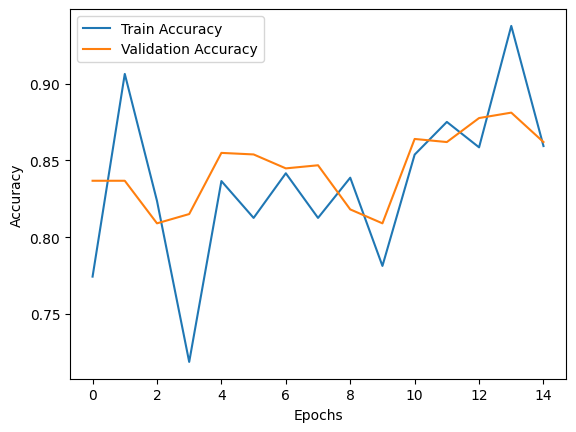

In [22]:
# Save Model
model.save("skin_cancer_cnn.h5")

# Plot Training History
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [23]:
# Predict on the test set
test_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)

# Convert predictions to binary labels (0 or 1)
test_pred_labels = (test_pred > 0.5).astype("int32")

# Get the true labels
test_true_labels = test_generator.classes[:len(test_pred_labels)]  # Match length to predictions

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.54      0.54      1000
           1       0.52      0.51      0.52       984

    accuracy                           0.53      1984
   macro avg       0.53      0.53      0.53      1984
weighted avg       0.53      0.53      0.53      1984

-------------------------------------------------------------------------


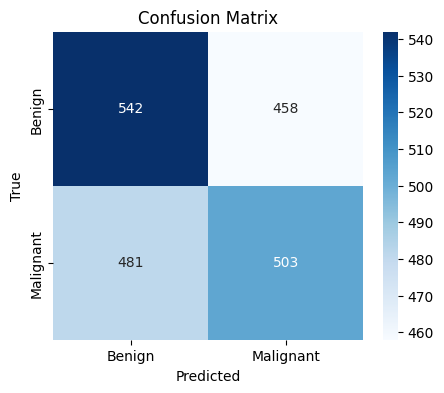

In [26]:
# Classification report
print("Classification Report:")
print(classification_report(test_true_labels, test_pred_labels))

# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)
print('-------------------------------------------------------------------------')
# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()